# **Classification - Titanic Dataset**

---

### Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

---

### Importing the dataset

In [2]:
# Importing the dataset
df = pd.read_csv('train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


---

### Data Preprocessing

In [3]:
# Checking for missing values for each column
pd.isnull(df).sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
# Checking the distribution of values in the 'Embarked' column
df['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [5]:
# Since 'S' is the mode in the 'Embarked' column, we will fill the missing values with 'S'
df.fillna({'Embarked': 'S'}, inplace=True)
df['Embarked'].value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [6]:
# Displaying summary statistics for the 'Age' column to understand its distribution
print(df['Age'].describe())

# Displaying the number of missing values in the 'Age' column
missing_age_count = pd.isnull(df["Age"]).sum()
print(f"Number of missing values in the 'Age' column: {missing_age_count}")

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
Number of missing values in the 'Age' column: 177


More than 20% of data in the 'Age' column are missing

In [7]:
# Creating a new feature to track missing values in the 'Age' column
df['MissingAge'] = np.where(df['Age'].isna(), 'Y', 'N')
df['MissingAge'].value_counts()

MissingAge
N    714
Y    177
Name: count, dtype: int64

In [8]:
# Creating a new feature 'FamilySize' by combining 'SibSp' and 'Parch'
df['FamilySize'] = 1 + df['SibSp'] + df['Parch']
df['FamilySize'].value_counts()

FamilySize
1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: count, dtype: int64

In [9]:
# Displaying data types of each column
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
MissingAge      object
FamilySize       int64
dtype: object

In [10]:
# Converting the data into categorical variables
categorical_cols = ['Survived', 'Pclass', 'Sex', 'Embarked', 'MissingAge']
for col in categorical_cols:
    df[col] = df[col].astype('category')
# Displaying data types of each column after conversion
df.dtypes

PassengerId       int64
Survived       category
Pclass         category
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
MissingAge     category
FamilySize        int64
dtype: object

The above code is the Python equivalent to setting up factors in R

---

#### Feature Selection

In [11]:
# Selecting the subset of features to be used in the model
features = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "MissingAge", "FamilySize"]
df = df[features]
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,MissingAge,FamilySize
0,0,3,male,22.0,1,0,7.2500,S,N,2
1,1,1,female,38.0,1,0,71.2833,C,N,2
2,1,3,female,26.0,0,0,7.9250,S,N,1
3,1,1,female,35.0,1,0,53.1000,S,N,2
4,0,3,male,35.0,0,0,8.0500,S,N,1
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,N,1
887,1,1,female,19.0,0,0,30.0000,S,N,1
888,0,3,female,NaN,1,2,23.4500,S,Y,4
889,1,1,male,26.0,0,0,30.0000,C,N,1


In [12]:
# Displaying the info of the dataframe to verify data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    category
 1   Pclass      891 non-null    category
 2   Sex         891 non-null    category
 3   Age         714 non-null    float64 
 4   SibSp       891 non-null    int64   
 5   Parch       891 non-null    int64   
 6   Fare        891 non-null    float64 
 7   Embarked    891 non-null    category
 8   MissingAge  891 non-null    category
 9   FamilySize  891 non-null    int64   
dtypes: category(5), float64(2), int64(3)
memory usage: 39.9 KB


---

##### One Hot Encoding

In [ ]:
# One hot encoding categorical variables (getting dummy variables), after dropping the target variable 'Survived' from the features
df_encoded = pd.get_dummies(df.drop('Survived', axis=1), dtype=int)
df_encoded

,Age,SibSp,Parch,Fare,FamilySize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,MissingAge_N,MissingAge_Y
0,22.0,1,0,7.2500,2,0,0,1,0,1,0,0,1,1,0
1,38.0,1,0,71.2833,2,1,0,0,1,0,1,0,0,1,0
2,26.0,0,0,7.9250,1,0,0,1,1,0,0,0,1,1,0
3,35.0,1,0,53.1000,2,1,0,0,1,0,0,0,1,1,0
4,35.0,0,0,8.0500,1,0,0,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,1,0,1,0,0,1,0,0,1,1,0
887,19.0,0,0,30.0000,1,1,0,0,1,0,0,0,1,1,0
888,NaN,1,2,23.4500,4,0,0,1,1,0,0,0,1,0,1
889,26.0,0,0,30.0000,1,1,0,0,0,1,1,0,0,1,0


In [14]:
# Displaying data types of each column in the encoded dataframe
df_encoded.dtypes

Age             float64
SibSp             int64
Parch             int64
Fare            float64
FamilySize        int64
Pclass_1          int64
Pclass_2          int64
Pclass_3          int64
Sex_female        int64
Sex_male          int64
Embarked_C        int64
Embarked_Q        int64
Embarked_S        int64
MissingAge_N      int64
MissingAge_Y      int64
dtype: object

In [15]:
# Checking for missing values in the encoded dataframe
pd.isnull(df_encoded).sum()

Age             177
SibSp             0
Parch             0
Fare              0
FamilySize        0
Pclass_1          0
Pclass_2          0
Pclass_3          0
Sex_female        0
Sex_male          0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
MissingAge_N      0
MissingAge_Y      0
dtype: int64

##### **Note**: Random Forests are the same as bagged decision trees, therefore we will be using the Iterative Imputer with a RandomForest estimator as a Python equivalent to impute the data using the "bagImpute" method in R.

In [16]:
# IterativeImputer with a RandomForest estimator is a strong Python equivalent for bagImpute
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=0),
    max_iter=5,
    random_state=0
)
imputed_array = imputer.fit_transform(df_encoded)

In [17]:
# Converting the imputed numpy array back to a pandas DataFrame
df_encoded = pd.DataFrame(imputed_array, columns=df_encoded.columns)
df_encoded

,Age,SibSp,Parch,Fare,FamilySize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,MissingAge_N,MissingAge_Y
0,22.00,1.0,0.0,7.2500,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,38.00,1.0,0.0,71.2833,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,26.00,0.0,0.0,7.9250,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,35.00,1.0,0.0,53.1000,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,35.00,0.0,0.0,8.0500,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.00,0.0,0.0,13.0000,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
887,19.00,0.0,0.0,30.0000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
888,17.02,1.0,2.0,23.4500,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
889,26.00,0.0,0.0,30.0000,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [18]:
# Updating the original dataframe with the imputed 'Age' values from the encoded dataframe
df.loc[:, 'Age'] = df_encoded['Age']

In [19]:
# Rechecking for missing values in the original dataframe after imputation and replacement
pd.isnull(df).sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
MissingAge    0
FamilySize    0
dtype: int64

All missing values successfully imputed.

##### Data Preprocessing complete.

---

##### In Python, we have to define the features (X) and the target variable (y) before using train test split.

In [20]:
# Defining features and target variable
X = df.drop('Survived', axis=1)
y = df['Survived']             

In [21]:
# Splitting the data using the "stratified" train_test_split method (This is equivalent to R's createDataPartition)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=54321, stratify=y)

In [22]:
# Checking the proportions of the target variable in the original df, y_train, and y_test
print("Proportions for 'train' DataFrame")
print(df['Survived'].value_counts(normalize=True))

print("\n" + "---" * 15 + "\n")

print("Proportion for 'y_train'")
print(y_train.value_counts(normalize=True))

print("\n" + "---" * 15 + "\n")

print("Proportions for 'y_test'")
print(y_test.value_counts(normalize=True))

Proportions for 'train' DataFrame
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

---------------------------------------------

Proportion for 'y_train'
Survived
0    0.616372
1    0.383628
Name: proportion, dtype: float64

---------------------------------------------

Proportions for 'y_test'
Survived
0    0.615672
1    0.384328
Name: proportion, dtype: float64


---

##### Defining Cross-Validation Strategy and Hyperparameter Grid

In [23]:
# Define the cross-validation strategy to perform 10-fold cross validation repeated 3 times
cv_strategy = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

In [24]:
# Defining the hyperparameter grid for tuning
tune_grid = {
    'learning_rate': [0.05, 0.075, 0.1],  # 'eta' in R
    'n_estimators': [50, 75, 100],        # 'nrounds' in R
    'max_depth': [6, 7, 8],               #  6:8 in R becomes a list in Python
    'min_child_weight': [2.0, 2.25, 2.5],
    'colsample_bytree': [0.3, 0.4, 0.5],
    'gamma': [0],                        
    'subsample': [1]                     
}

print("Hyperparameter grid for tuning:")
tune_grid

Hyperparameter grid for tuning:


{'learning_rate': [0.05, 0.075, 0.1],
 'n_estimators': [50, 75, 100],
 'max_depth': [6, 7, 8],
 'min_child_weight': [2.0, 2.25, 2.5],
 'colsample_bytree': [0.3, 0.4, 0.5],
 'gamma': [0],
 'subsample': [1]}

---

##### **Note**: The code to create a socket-based parallel cluster with 10 workers and registration for use in parallel computations will be skipped since it's meant for high-end workstations.

---

### Model Training and Hyperparameter Tuning

In [25]:
# Initializing and configuring the XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=54321, verbosity=0, enable_categorical=True)

# Set up the GridSearchCV for hyperparameter tuning
grid = GridSearchCV(
    estimator=xgb,
    param_grid=tune_grid,
    scoring='accuracy',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=2
)

# Fit the model using the training data to find the best hyperparameters
grid.fit(X_train, y_train)

Fitting 30 folds for each of 243 candidates, totalling 7290 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.3, 0.4, ...], 'gamma': [0], 'learning_rate': [0.05, 0.075, ...], 'max_depth': [6, 7, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,RepeatedStrat...ndom_state=42)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [26]:
# Displaying the results of hyperparameter tuning in a dataframe
results_df = pd.DataFrame(grid.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,0.055314,0.042658,0.010810,0.008822,0.3,0,0.05,6,2.00,50,...,0.661290,0.677419,0.806452,0.806452,0.806452,0.709677,0.774194,0.749019,0.045963,240
1,0.042281,0.007199,0.006938,0.005246,0.3,0,0.05,6,2.00,75,...,0.661290,0.725806,0.870968,0.838710,0.870968,0.709677,0.806452,0.784332,0.055813,210
2,0.051157,0.006051,0.008521,0.006525,0.3,0,0.05,6,2.00,100,...,0.709677,0.725806,0.903226,0.838710,0.887097,0.725806,0.838710,0.797721,0.054711,172
3,0.033313,0.008579,0.008782,0.007541,0.3,0,0.05,6,2.25,50,...,0.661290,0.677419,0.790323,0.822581,0.790323,0.709677,0.774194,0.750606,0.045711,236
4,0.043226,0.005180,0.007045,0.003716,0.3,0,0.05,6,2.25,75,...,0.677419,0.709677,0.854839,0.806452,0.854839,0.725806,0.806452,0.784323,0.054415,211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,0.047404,0.004673,0.006413,0.002679,0.5,0,0.10,8,2.25,75,...,0.741935,0.758065,0.903226,0.790323,0.854839,0.725806,0.854839,0.812144,0.043847,79
239,0.059694,0.005474,0.006600,0.002283,0.5,0,0.10,8,2.25,100,...,0.741935,0.758065,0.903226,0.806452,0.854839,0.741935,0.838710,0.813774,0.044612,48
240,0.035508,0.003824,0.006380,0.002412,0.5,0,0.10,8,2.50,50,...,0.725806,0.758065,0.903226,0.822581,0.870968,0.693548,0.838710,0.815344,0.051061,30
241,0.047881,0.003907,0.006149,0.001922,0.5,0,0.10,8,2.50,75,...,0.709677,0.741935,0.903226,0.806452,0.854839,0.709677,0.854839,0.812118,0.051170,82


In [27]:
# Printing the best parameters and the best cross-validation score
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

Best parameters: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.075, 'max_depth': 7, 'min_child_weight': 2.0, 'n_estimators': 100, 'subsample': 1}
Best cross-validation score: 0.8190988223246286


##### The model performance metrics may not be identical since the optimal hyperparameters identified by GridSearchCV were different from the R code in the Youtube video. (And due to randomization)

In [28]:
# Making predictions on the test set using the optimal hyperparameters
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

#### Evaluating Model Performance

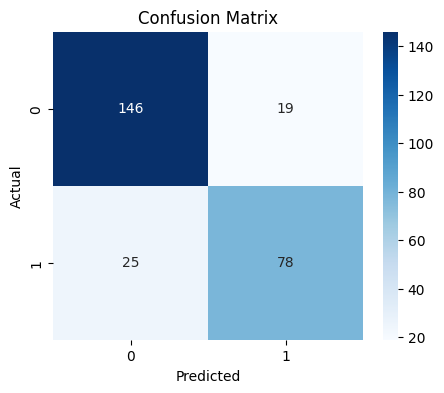


Classification report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       165
           1       0.80      0.76      0.78       103

    accuracy                           0.84       268
   macro avg       0.83      0.82      0.82       268
weighted avg       0.83      0.84      0.83       268



In [29]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification report:")
print(classification_report(y_test, y_pred))

##### The classification report is the Python equivalent of R's confusionMatrix function from the caret package.

---